# Курс Спортивный анализ данных. Платформа Kaggle

# Практическое задание урока 2. Обзор основных алгоритмов машинного обучения, используемых в соревнованиях

В домашнем задании, будем обучать разные алгоритмы машинного обучения. Для этого, нужно предварительно зафиксировать схему валидации решения (можете выбрать любую, которую знаете). Выбранную схему валидации нужно использовать во всех задачах этого домашнего задания. Метрика качества - ROC AUC, целевая переменная - isFraud.

Ссылка на данные - https://drive.google.com/file/d/1gMEVl47pIoV1-AseB9doQ6DZNJrY3NkW/view?usp=sharing


## Подключение библиотек и скриптов

In [20]:
import warnings
import numpy as np
import pandas as pd
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, plot_roc_curve

from pathlib import Path

warnings.simplefilter("ignore")

## Пути к директориям и файлам

In [21]:
DATA_ROOT = Path('D:/DS_materials/208_kaggle/data/')

# input
TRAIN_DATASET_PATH = DATA_ROOT / 'assignment_2_train.csv'
TEST_DATASET_PATH = DATA_ROOT / 'assignment_2_test.csv'

## Загрузка данных

In [22]:
base_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [23]:
print("train_df.shape = {} rows, {} cols".format(*train_df.shape))
print("test_df.shape = {} rows, {} cols".format(*test_df.shape))
train_df.head(n=2)

train_df.shape = 180000 rows, 394 cols
test_df.shape = 100001 rows, 394 cols


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
target = train_df['isFraud']
train_df = train_df.drop(['isFraud', 'TransactionID', 'TransactionDT'], axis=1)
print("train_df.shape = {} rows, {} cols".format(*train_df.shape))

train_df.shape = 180000 rows, 391 cols


## Подготовка данных

In [25]:
numerical_features = train_df.select_dtypes(include=[np.number]).columns
#print(f"count of numeric features {numerical_features.shape[1]}")
numerical_features

Index(['TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2',
       'dist1', 'dist2', 'C1',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=377)

In [26]:
categorical_features = train_df.select_dtypes(include=[np.object]).columns

#print(f"count of categorical features {categorical_features.shape[1]}")
#categorical_features.head(n=2)
categorical_features

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'],
      dtype='object')

In [27]:
train_df[categorical_features] = train_df[categorical_features].astype(str)

## XGBoost

### Задание 1:
* отобрать только числовые признаки и обучить модель XGBoost с параметром booster = gbtree. 

* Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [34]:
x_train_num, x_valid_num = train_test_split(
    train_df[numerical_features], train_size=0.8, random_state=42
)
y_train, y_valid = train_test_split(
    target, train_size=0.8, random_state=42
)
print("x_train_num.shape = {} rows, {} cols".format(*x_train_num.shape))
print("x_valid_num.shape = {} rows, {} cols".format(*x_valid_num.shape))

x_train_num.shape = 144000 rows, 377 cols
x_valid_num.shape = 36000 rows, 377 cols


Используем XGBoost sklearn-API

In [29]:
params_xgb = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

In [51]:
eval_set_num = [
    (x_train_num, y_train),
    (x_valid_num, y_valid)]

In [36]:
%%time

model_xgb_num = xgb.XGBClassifier(**params_xgb)

model_xgb_num.fit(
    X=x_train_num, 
    y=y_train,
    eval_set=eval_set_num, 
    early_stopping_rounds=50,
    eval_metric="auc",
    verbose=50)

[0]	validation_0-auc:0.65232	validation_1-auc:0.63974
[50]	validation_0-auc:0.87929	validation_1-auc:0.87059
[100]	validation_0-auc:0.89286	validation_1-auc:0.88227
[150]	validation_0-auc:0.90079	validation_1-auc:0.88859
[200]	validation_0-auc:0.90341	validation_1-auc:0.89061
[215]	validation_0-auc:0.90341	validation_1-auc:0.89061
Wall time: 2min 12s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=10, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=6, nthread=6,
              num_parallel_tree=1, random_state=27, reg_alpha=0, reg_lambda=100,
              scale_pos_weight=1, seed=27, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

### Задание 2: 
обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 1

In [37]:
train_cat = train_df.copy()

for cat_colname in train_df.select_dtypes(include='object').columns[1:]:
    train_cat = pd.concat([train_cat, pd.get_dummies(train_df[cat_colname], prefix=cat_colname)], axis=1)

In [38]:
train_cat.head(2)

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,M6_nan,M7_F,M7_T,M7_nan,M8_F,M8_T,M8_nan,M9_F,M9_T,M9_nan
0,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,...,0,0,0,1,0,0,1,0,0,1
1,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,...,0,0,0,1,0,0,1,0,0,1


In [39]:
for cat_colname in categorical_features:
    train_cat = train_cat.drop([cat_colname], axis=1)
    
print("train_cat.shape = {} rows, {} cols".format(*train_cat.shape))

train_cat.shape = 180000 rows, 536 cols


In [41]:
x_train_cat, x_valid_cat = train_test_split(
    train_cat, train_size=0.8, random_state=42
)

print("x_train_cat.shape = {} rows, {} cols".format(*x_train_cat.shape))
print("x_valid_cat.shape = {} rows, {} cols".format(*x_valid_cat.shape))

x_train_cat.shape = 144000 rows, 536 cols
x_valid_cat.shape = 36000 rows, 536 cols


In [50]:
eval_set_cat = [
    (x_train_cat, y_train),
    (x_valid_cat, y_valid)]

In [43]:
%%time

model_xgb_cat = xgb.XGBClassifier(**params_xgb)

model_xgb_cat.fit(X=x_train_cat, y=y_train,
            eval_set=eval_set_cat, 
            early_stopping_rounds=50,
            eval_metric="auc",
            verbose=50)

[0]	validation_0-auc:0.65232	validation_1-auc:0.63974
[50]	validation_0-auc:0.88791	validation_1-auc:0.87767
[100]	validation_0-auc:0.90476	validation_1-auc:0.89085
[150]	validation_0-auc:0.91033	validation_1-auc:0.89625
[186]	validation_0-auc:0.91033	validation_1-auc:0.89625
Wall time: 2min 39s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=10, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=6, nthread=6,
              num_parallel_tree=1, random_state=27, reg_alpha=0, reg_lambda=100,
              scale_pos_weight=1, seed=27, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

## LightGBM

### Задание 4: 
* для числовых признаков обучить модель LightGBM. 

* Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [52]:
params_lgb = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 200,
    "n_jobs": 6,
    "seed": 27
}

In [53]:
%%time

model_lgb_num = lgb.LGBMClassifier(**params_lgb)

model_lgb_num.fit(X=x_train_num, y=y_train,
            eval_set=eval_set_num,
            early_stopping_rounds=25,
            eval_metric="auc",
            verbose=50)

Training until validation scores don't improve for 25 rounds
[50]	training's auc: 0.872647	valid_1's auc: 0.864697
[100]	training's auc: 0.888945	valid_1's auc: 0.877939
[150]	training's auc: 0.896954	valid_1's auc: 0.884614
[200]	training's auc: 0.905545	valid_1's auc: 0.892155
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.905545	valid_1's auc: 0.892155
Wall time: 22 s


LGBMClassifier(learning_rate=0.01, metric='auc', n_estimators=200, n_jobs=6,
               objective='binary', seed=27)

### Задание 5: 
* обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. 
* Выполнить задание 4.

In [55]:
%%time

model_lgb_cat = lgb.LGBMClassifier(**params_lgb)

model_lgb_cat.fit(X=x_train_cat, y=y_train,
            eval_set=eval_set_cat,
            early_stopping_rounds=25,
            eval_metric="auc",
            verbose=50)

Training until validation scores don't improve for 25 rounds
[50]	training's auc: 0.881583	valid_1's auc: 0.872063
[100]	training's auc: 0.898136	valid_1's auc: 0.882805
[150]	training's auc: 0.90572	valid_1's auc: 0.890219
[200]	training's auc: 0.915368	valid_1's auc: 0.89779
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.915368	valid_1's auc: 0.89779
Wall time: 22.8 s


LGBMClassifier(learning_rate=0.01, metric='auc', n_estimators=200, n_jobs=6,
               objective='binary', seed=27)

### Задание 6: 
* обработать категориальные признаки встроенным методом в LightGBM. 
* Выполнить задание 4. 
* Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 5.

In [57]:
train_num_cat = train_df.copy()

In [58]:
for c in categorical_features:
    train_num_cat[c] = train_num_cat[c].astype('category')

In [59]:
x_train_num_cat, x_valid_num_cat = train_test_split(
    train_num_cat, train_size=0.8, random_state=42
)

In [60]:
cat_features = list(categorical_features)
cat_features

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9']

In [62]:
eval_set_num_cat = [
    (x_train_num_cat, y_train),
    (x_valid_num_cat, y_valid)]

In [63]:
%%time

model_lgb_num_cat = lgb.LGBMClassifier(**params_lgb)

model_lgb_num_cat.fit(X=x_train_num_cat, y=y_train,
            eval_set=eval_set_num_cat,
            categorical_feature=cat_features,
            early_stopping_rounds=25,
            eval_metric="auc",
            verbose=50)

Training until validation scores don't improve for 25 rounds
[50]	training's auc: 0.882528	valid_1's auc: 0.87291
[100]	training's auc: 0.89601	valid_1's auc: 0.886373
[150]	training's auc: 0.909522	valid_1's auc: 0.894408
[200]	training's auc: 0.917555	valid_1's auc: 0.901744
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.917555	valid_1's auc: 0.901744
Wall time: 24.3 s


LGBMClassifier(learning_rate=0.01, metric='auc', n_estimators=200, n_jobs=6,
               objective='binary', seed=27)

**Вывод:**
При обработке категориальных признаков встроенным методом в LightGBMа score на валидационных данных немного выше, чем при обработке вручную.

## CatBoost

### Задание 7: 
* для числовых признаков обучить модель CatBoost. 
* Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [67]:
params_cb = {
    "n_estimators": 10000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 500,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

In [68]:
model_cb_num = cb.CatBoostClassifier(**params_cb)
model_cb_num.fit(x_train_num, y_train, 
                 eval_set=[(x_train_num, y_train), (x_valid_num, y_valid)])

0:	test: 0.6880634	test1: 0.6744911	best: 0.6744911 (0)	total: 333ms	remaining: 55m 29s
500:	test: 0.8873154	test1: 0.8803184	best: 0.8803184 (500)	total: 1m 16s	remaining: 24m 11s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8805193321
bestIteration = 650

Shrink model to first 651 iterations.


### Задание 8: 
* обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. 
* Выполнить задание 7.

In [69]:
%%time 

model_cb_cat = cb.CatBoostClassifier(**params_cb)

model_cb_cat.fit(x_train_cat, y_train, 
                     eval_set=[(x_train_cat, y_train), (x_valid_cat, y_valid)])

0:	test: 0.6254659	test1: 0.6212908	best: 0.6212908 (0)	total: 175ms	remaining: 29m 10s
500:	test: 0.8940424	test1: 0.8848354	best: 0.8848354 (500)	total: 1m 17s	remaining: 24m 32s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.885152757
bestIteration = 562

Shrink model to first 563 iterations.
Wall time: 1min 38s


### Задание 9: 
* обработать категориальные признаки встроенным методом в CatBoost. 
* Выполнить задание 7. 
* Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 8.

In [72]:
x_train_num_str, x_valid_num_str = train_test_split(
    train_df, train_size=0.8, random_state=42
)

In [73]:
eval_set_num_str = [
    (x_train_num_str, y_train),
    (x_valid_num_str, y_valid)]

In [74]:
%%time 

model_cb_num_cat = cb.CatBoostClassifier(**params_cb)

model_cb_num_cat.fit(x_train_num_str,
                     y_train,
                     cat_features=cat_features,
                     eval_set=eval_set_num_str)

0:	test: 0.5955634	test1: 0.5949732	best: 0.5949732 (0)	total: 745ms	remaining: 2h 4m 10s
500:	test: 0.8966389	test1: 0.8865379	best: 0.8865386 (499)	total: 5m 43s	remaining: 1h 48m 36s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8870876142
bestIteration = 640

Shrink model to first 641 iterations.
Wall time: 7min 50s


**Вывод:**
При применении CatBoost наиболее высокий score на валидационных данных представлен в случае обработки категориальных признаков встроенным методом.

### Задание 10: 
* построить ROC-кривую для всех построенных алгоритмов на обучающей и тестовой выборке. 
* Сделать выводы о работе алгоритмов с точки зрения качества на тестовой выборке и с точки зрения переобучения.

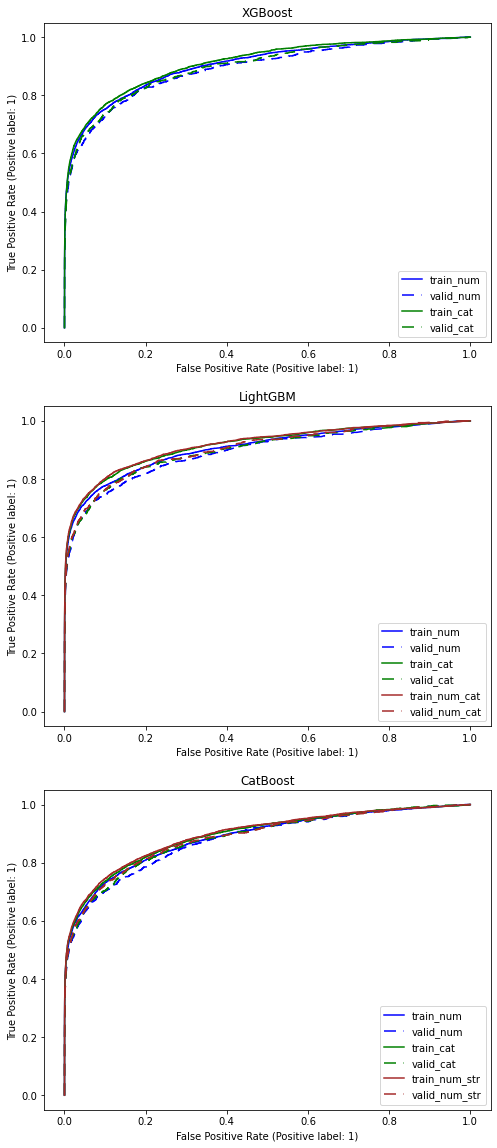

In [77]:
fig, axes = plt.subplots(3, 1, figsize=(8, 20))

axes[0].set_title("XGBoost", fontsize=12)

plot_roc_curve(model_xgb_num, x_train_num, y_train, ax=axes[0], label='train_num', c='blue')
plot_roc_curve(model_xgb_num, x_valid_num, y_valid, ax=axes[0], label='valid_num', c='blue', dashes=[8, 5])
plot_roc_curve(model_xgb_cat, x_train_cat, y_train, ax=axes[0], label='train_cat', c='green')
plot_roc_curve(model_xgb_cat, x_valid_cat, y_valid, ax=axes[0], label='valid_cat', c='green', dashes=[8, 5])

axes[1].set_title("LightGBM", fontsize=12)

plot_roc_curve(model_lgb_num, x_train_num, y_train, ax=axes[1], label='train_num', c='blue')
plot_roc_curve(model_lgb_num, x_valid_num, y_valid, ax=axes[1], label='valid_num', c='blue', dashes=[8, 5])
plot_roc_curve(model_lgb_cat, x_train_cat, y_train, ax=axes[1], label='train_cat', c='green')
plot_roc_curve(model_lgb_cat, x_valid_cat, y_valid, ax=axes[1], label='valid_cat', c='green', dashes=[8, 5])
plot_roc_curve(model_lgb_num_cat, x_train_num_cat, y_train, ax=axes[1], label='train_num_cat', c='brown')
plot_roc_curve(model_lgb_num_cat, x_valid_num_cat, y_valid, ax=axes[1], label='valid_num_cat', c='brown', dashes=[8, 5])

axes[2].set_title("CatBoost", fontsize=12)

plot_roc_curve(model_cb_num, x_train_num, y_train, ax=axes[2], label='train_num', c='blue')
plot_roc_curve(model_cb_num, x_valid_num, y_valid, ax=axes[2], label='valid_num', c='blue', dashes=[8, 5])
plot_roc_curve(model_cb_cat, x_train_cat, y_train, ax=axes[2], label='train_cat', c='green')
plot_roc_curve(model_cb_cat, x_valid_cat, y_valid, ax=axes[2], label='valid_cat', c='green', dashes=[8, 5])
plot_roc_curve(model_cb_num_cat, x_train_num_str, y_train, ax=axes[2], label='train_num_str', c='brown')
plot_roc_curve(model_cb_num_cat, x_valid_num_str, y_valid, ax=axes[2], label='valid_num_str', c='brown', dashes=[8, 5])

**Вывод:**

При применении LightGBM по сравнению с другими моделями score на валидационных данных немного выше.
